<a href="https://colab.research.google.com/github/BhagyaC/ict_course/blob/master/TF_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
# import explainable_ai_sdk

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
# from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

In [3]:
!gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .


Copying gs://financial_fraud_detection/fraud_data_kaggle.csv...
/ [1 files][303.4 MiB/303.4 MiB]                                                
Operation completed over 1 objects/303.4 MiB.                                    


In [4]:
data = pd.read_csv('fraud_data_kaggle.csv')
data = data.drop(columns=['type'])
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


After looking to the data we can see the imbalance and hence we need to reduce the ratio of data using downsampling to address the data imbalance ( making the data ratio 1:99 to 25:75 )

In [5]:
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

In [13]:
print(len(fraud))
print(len(not_fraud))

3411
4103092


In [14]:
# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)

# Remove a few columns (isFraud is the label column we'll use, not isFlaggedFraud)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# Preview the updated dataset
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2880934,228,225995.98,187387.00,0.00,2089592.81,2315588.79,0.0
2485109,204,6758.80,25491.67,18732.88,0.00,0.00,0.0
3528108,259,21772.92,26341.00,4568.08,0.00,0.00,0.0
199110,13,582526.39,0.00,0.00,1110543.49,1693069.89,0.0
550022,21,93966.17,0.00,0.00,3581536.71,3675502.88,0.0


After addressing the data imbalance split the data into train and test

In [15]:
train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')

Data Normalisation

In [18]:
scaler = StandardScaler()
train_set = scaler.fit_transform(train_set) # Only normalize on the train set
test_set = scaler.transform(test_set)

# clip() ensures all values fall within the range [-5,5]
# useful if any outliers remain after normalizing
train_set = np.clip(train_set, -5, 5)
test_set = np.clip(test_set, -5, 5)

In [19]:
train_set

array([[ 0.74771568, -0.10558206, -0.24744663, -0.26469104,  0.51385876,
         0.48591169],
       [ 0.48352495, -0.33128635, -0.30457304, -0.25780596, -0.39568077,
        -0.43989138],
       [ 1.08896205, -0.31582934, -0.30427334, -0.26301209, -0.39568077,
        -0.43989138],
       ...,
       [-1.63000093, -0.2417149 ,  5.        ,  5.        , -0.32594475,
        -0.41332417],
       [ 0.50554084, -0.24271814, -0.31319682, -0.26469104, -0.39568077,
        -0.40279301],
       [-0.43013468, -0.28420772,  2.89581808,  3.09750739, -0.18409246,
        -0.26652501]])

In [21]:
scaler = StandardScaler()
weight_for_non_fraud = 1.0 / df['isFraud'].value_counts()[0]
weight_for_fraud = 1.0 / df['isFraud'].value_counts()[1]

class_weight = {0: weight_for_non_fraud, 1: weight_for_fraud}

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS):
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_set.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

The following are some global variables and stopping parameters

In [24]:
EPOCHS = 100
BATCH_SIZE = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [25]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [26]:
results = model.fit(
    train_set,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(test_set, test_labels),
    class_weight=class_weight)

Epoch 1/100
38/38 [==============================] - 3s 30ms/step - loss: 7.1009e-05 - tp: 1037.6410 - fp: 6797.9744 - tn: 1957.0769 - fn: 417.9744 - accuracy: 0.2918 - precision: 0.1333 - recall: 0.7164 - auc: 0.4480 - val_loss: 0.9121 - val_tp: 639.0000 - val_fp: 4002.0000 - val_tn: 82.0000 - val_fn: 63.0000 - val_accuracy: 0.1506 - val_precision: 0.1377 - val_recall: 0.9103 - val_auc: 0.4711
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 6.6437e-05 - tp: 1009.0513 - fp: 6240.9231 - tn: 2508.6667 - fn: 452.0256 - accuracy: 0.3388 - precision: 0.1394 - recall: 0.6888 - auc: 0.4815 - val_loss: 0.8209 - val_tp: 554.0000 - val_fp: 3328.0000 - val_tn: 756.0000 - val_fn: 148.0000 - val_accuracy: 0.2737 - val_precision: 0.1427 - val_recall: 0.7892 - val_auc: 0.5567
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 6.0958e-05 - tp: 954.7692 - fp: 5241.6923 - tn: 3534.0256 - fn: 480.1795 - accuracy: 0.4311 - precision: 0.1528 - recall: 0.6692 -

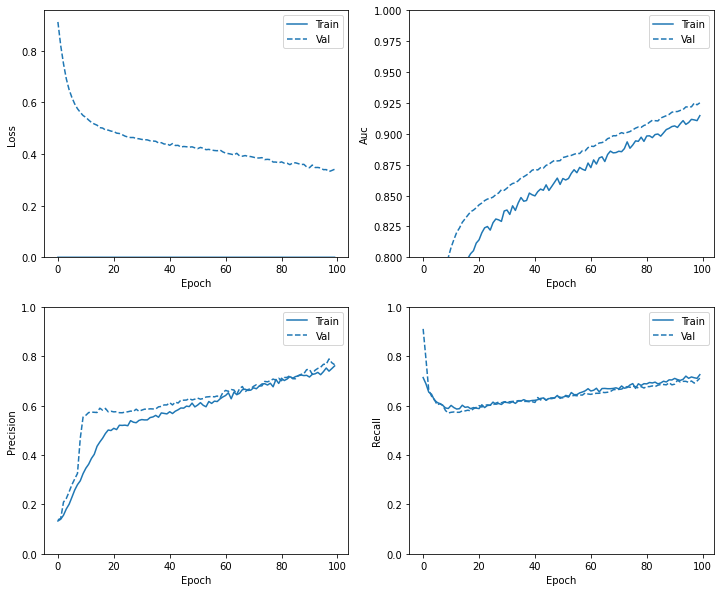

In [27]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(results)

In [28]:
predicted = model.predict(test_set)

y_pred = []

for i in predicted.tolist():
  y_pred.append(int(round(i[0])))

In [29]:
cm = confusion_matrix(test_labels.values, y_pred)
print(cm)

[[3931  153]
 [ 203  499]]


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

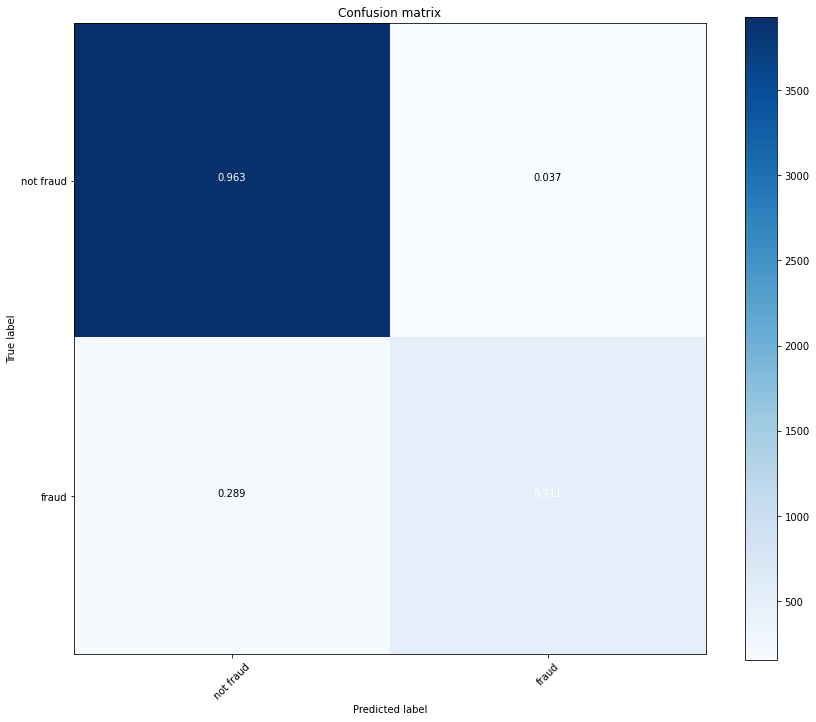

In [32]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

**Explainable SDK**

In [ ]:
# exporting the trained model
model_dir = 'fraud_model'
tf.saved_model.save(model, model_dir)

#get explanation metadata with SDK
model_builder = SavedModelMetadataBuilder(model_dir)
metadata = model_builder.get_metadata()
print(metadata)

#specify our model baselines
'''
For tabular data the Explainable AI service words by returning attribution values for each feature.
These values indicate how much a particular feature affected to a prediction

When we say this particular feature cause a improvement in fraud probability by 2% then we might have a question of what exactly 
is the baseline

So baseline is something that we what we compare against. We select the baseline values for eacch feature in our model and the baseline 
prediction consequently becomes the values our model predict when the features are set at the baseline

Baseline selection depends on what the problem statement
For numerical features it is common to use median value
We care most about explaining the cases when our model labels a transaction as fraudulent.
That means the baseline case we want to compare against is non-fraudulent transactions.

To account for this, we'll use the median values of the non-fraudulent transactions in our dataset as the baseline.
We can get the median by using the not_fraud_sample DataFrame we extracted above, and scaling it to match our model's expected inputs:
'''

not_fraud_sample = not_fraud_sample.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud'])

baseline = scaler.transform(not_fraud_sample.values)
baseline = np.clip(baseline, -5, 5)
baseline_values = np.median(baseline, axis=0)

input_name = list(metadata['inputs'])[0]
model_builder.set_numeric_metadata(input_name, input_baselines=[baseline_values.tolist()], index_feature_mapping=df.columns.tolist()[:6])
model_builder.save_metadata(model_dir)

'''
Running the save_metadata() method above created a file in our model's directory called explanation_metadata.json. 
'''
local_model = explainable_ai_sdk.load_model_from_local_path(
    model_dir, 
    explainable_ai_sdk.SampledShapleyConfig()
)

fraud_example = [0.722,0.139,-0.114,-0.258,-0.271,-0.305]
response = local_model.explain([{input_name: fraud_example}])
response[0].visualize_attributions()


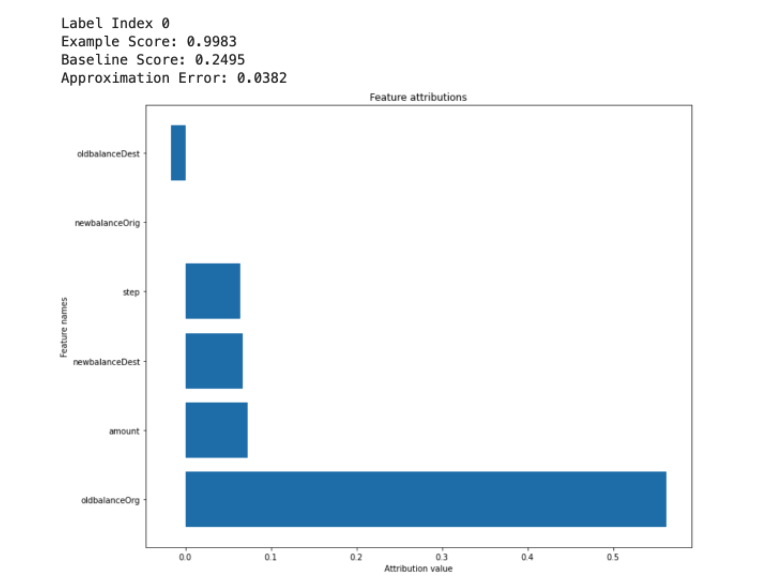

There is lots more you can do with Explainable AI on this model. Some ideas include:

Sending many examples to our model and averaging the attribution values to see if certain features are more important overall. We could use this to improve our model, and potentially remove features that aren't important
Finding false positives that our model flags as fraud but are non-fraudulent transactions, and examining their attribution values
Use a different baseline and see how this impacts the attribution values